# Use python class build a *model* `class`

## - 1. With the dropout layer between convolution layers
## - 2. Without the dropout layer between convolution layers


## 1. With the dropout layer between convolution layers

### -  Class Structure
### -  Use this model for training and evaluation
### -  predict method

### Class Structure

### Use this model for training and evaluation

 - initialize a sess
 - instance the model class `m1`
 - initialize the gloabal variables

 - batch-train 
  - call `m1.train()`
  - call `m1.get_accuracy()`
  - call `m1.predict()`


  
### coding

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100


class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.keep_prob = tf.placeholder(tf.float32)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 784])
            # img 28x28x1 (black/white)
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])

            # L1 ImgIn shape=(?, 28, 28, 1)
            W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
            #    Conv     -> (?, 28, 28, 32)
            #    Pool     -> (?, 14, 14, 32)
            L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
            L1 = tf.nn.relu(L1)
            L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')
            L1 = tf.nn.dropout(L1, keep_prob=self.keep_prob)
            '''
            Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
            Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
            Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
            Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)
            '''

            # L2 ImgIn shape=(?, 14, 14, 32)
            W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
            #    Conv      ->(?, 14, 14, 64)
            #    Pool      ->(?, 7, 7, 64)
            L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
            L2 = tf.nn.relu(L2)
            L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')
            L2 = tf.nn.dropout(L2, keep_prob=self.keep_prob)
            '''
            Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
            Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
            Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
            Tensor("dropout_1/mul:0", shape=(?, 7, 7, 64), dtype=float32)
            '''

            # L3 ImgIn shape=(?, 7, 7, 64)
            W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
            #    Conv      ->(?, 7, 7, 128)
            #    Pool      ->(?, 4, 4, 128)
            #    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
            L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
            L3 = tf.nn.relu(L3)
            L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                                1, 2, 2, 1], padding='SAME')
            L3 = tf.nn.dropout(L3, keep_prob=self.keep_prob)

            L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])
            '''
            Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
            Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
            Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
            Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
            Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)
            '''

            # L4 FC 4x4x128 inputs -> 625 outputs
            W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                                 initializer=tf.contrib.layers.xavier_initializer())
            b4 = tf.Variable(tf.random_normal([625]))
            L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
            L4 = tf.nn.dropout(L4, keep_prob=self.keep_prob)
            '''
            Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
            Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
            '''

            # L5 Final FC 625 inputs -> 10 outputs
            W5 = tf.get_variable("W5", shape=[625, 10],
                                 initializer=tf.contrib.layers.xavier_initializer())
            b5 = tf.Variable(tf.random_normal([10]))
            self.logits = tf.matmul(L4, W5) + b5
            '''
            Tensor("add_1:0", shape=(?, 10), dtype=float32)
            '''

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, keep_prop=1.0):
        return self.sess.run(self.logits, feed_dict={self.X: x_test, self.keep_prob: keep_prop})

    def get_accuracy(self, x_test, y_test, keep_prop=1.0):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.keep_prob: keep_prop})

    def train(self, x_data, y_data, keep_prop=0.7):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.keep_prob: keep_prop})

# initialize
sess = tf.Session()
m1 = Model(sess, "m1")

sess.run(tf.global_variables_initializer())

print('Learning Started!')

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        c, _ = m1.train(batch_xs, batch_ys)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy
print('Accuracy:', m1.get_accuracy(mnist.test.images, mnist.test.labels))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Learning Started!
Epoch: 0001 cost = 0.410797768
Epoch: 0002 cost = 0.099221889
Epoch: 0003 cost = 0.074386678
Epoch: 0004 cost = 0.061077834
Epoch: 0005 cost = 0.052385165
Epoch: 0006 cost = 0.047263925
Epoch: 0007 cost = 0.042160324
Epoch: 0008 cost = 0.040044826
Epoch: 0009 cost = 0.037071322
Epoch: 0010 cost = 0.033443693
Epoch: 0011 cost = 0.029538069
Epoch: 0012 cost = 0.031093850
Epoch: 0013 cost = 0.028803501
Epoch: 0014 cost = 0.026918820
Epoch: 0015 cost = 0.025720305
Learning Finished!
Accuracy: 0.9925


## predict method

`def predict(self, x_test, keep_prop=1.0):`     
   ` return self.sess.run(self.logits, feed_dict={self.X: x_test, self.keep_prob: keep_prop})`


Label:  [1]
Prediction: [1]


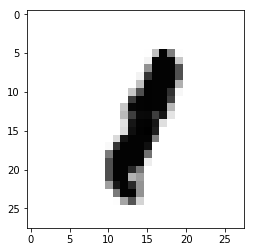

In [7]:
import random
import matplotlib.pyplot as plt
# Get one and predict
r = random.randint(0, mnist.test.num_examples - 1)
print("Label: ", sess.run(tf.argmax(mnist.test.labels[r:r + 1], 1)))
#print("Prediction: ", sess.run(
#   tf.argmax(logits, 1), feed_dict={X: mnist.test.images[r:r + 1], keep_prob: 1}))
print('Prediction:',sess.run(tf.argmax(m1.predict(mnist.test.images[r:r + 1]), 1)))
plt.imshow(mnist.test.images[r:r + 1].
          reshape(28, 28), cmap='Greys', interpolation='nearest')
plt.show()

# 2. Without the dropout layer between convolution layers

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

tf.set_random_seed(777)  # reproducibility

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

# hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100


class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._build_net()

    def _build_net(self):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.keep_prob = tf.placeholder(tf.float32)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 784])
            # img 28x28x1 (black/white)
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])
            self.Y = tf.placeholder(tf.float32, [None, 10])

            # L1 ImgIn shape=(?, 28, 28, 1)
            W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
            #    Conv     -> (?, 28, 28, 32)
            #    Pool     -> (?, 14, 14, 32)
            L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
            L1 = tf.nn.relu(L1)
            L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')
            #L1 = tf.nn.dropout(L1, keep_prob=self.keep_prob)
            '''
            Tensor("Conv2D:0", shape=(?, 28, 28, 32), dtype=float32)
            Tensor("Relu:0", shape=(?, 28, 28, 32), dtype=float32)
            Tensor("MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
            # Tensor("dropout/mul:0", shape=(?, 14, 14, 32), dtype=float32)
            '''

            # L2 ImgIn shape=(?, 14, 14, 32)
            W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
            #    Conv      ->(?, 14, 14, 64)
            #    Pool      ->(?, 7, 7, 64)
            L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
            L2 = tf.nn.relu(L2)
            L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], padding='SAME')
            #L2 = tf.nn.dropout(L2, keep_prob=self.keep_prob)
            '''
            Tensor("Conv2D_1:0", shape=(?, 14, 14, 64), dtype=float32)
            Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
            Tensor("MaxPool_1:0", shape=(?, 7, 7, 64), dtype=float32)
            Tensor("dropout_1/mul:0", shape=(?, 7, 7, 64), dtype=float32)
            '''

            # L3 ImgIn shape=(?, 7, 7, 64)
            W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
            #    Conv      ->(?, 7, 7, 128)
            #    Pool      ->(?, 4, 4, 128)
            #    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
            L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
            L3 = tf.nn.relu(L3)
            L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                                1, 2, 2, 1], padding='SAME')
            # before the FC layer,leave this dropout
            L3 = tf.nn.dropout(L3, keep_prob=self.keep_prob)

            L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])
            '''
            Tensor("Conv2D_2:0", shape=(?, 7, 7, 128), dtype=float32)
            Tensor("Relu_2:0", shape=(?, 7, 7, 128), dtype=float32)
            Tensor("MaxPool_2:0", shape=(?, 4, 4, 128), dtype=float32)
            Tensor("dropout_2/mul:0", shape=(?, 4, 4, 128), dtype=float32)
            Tensor("Reshape_1:0", shape=(?, 2048), dtype=float32)
            '''

            # L4 FC 4x4x128 inputs -> 625 outputs
            W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                                 initializer=tf.contrib.layers.xavier_initializer())
            b4 = tf.Variable(tf.random_normal([625]))
            L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
            # ?
            L4 = tf.nn.dropout(L4, keep_prob=self.keep_prob)
            '''
            Tensor("Relu_3:0", shape=(?, 625), dtype=float32)
            Tensor("dropout_3/mul:0", shape=(?, 625), dtype=float32)
            '''

            # L5 Final FC 625 inputs -> 10 outputs
            W5 = tf.get_variable("W5", shape=[625, 10],
                                 initializer=tf.contrib.layers.xavier_initializer())
            b5 = tf.Variable(tf.random_normal([10]))
            self.logits = tf.matmul(L4, W5) + b5
            '''
            Tensor("add_1:0", shape=(?, 10), dtype=float32)
            '''

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(
            tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, keep_prop=1.0):
        return self.sess.run(self.logits, feed_dict={self.X: x_test, self.keep_prob: keep_prop})

    def get_accuracy(self, x_test, y_test, keep_prop=1.0):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.keep_prob: keep_prop})

    def train(self, x_data, y_data, keep_prop=0.7):
        return self.sess.run([self.cost, self.optimizer], feed_dict={
            self.X: x_data, self.Y: y_data, self.keep_prob: keep_prop})

# initialize
sess = tf.Session()

#　ValueError: Variable m1/W4 already exists, disallowed. 
m2 = Model(sess, "m2")

sess.run(tf.global_variables_initializer())

print('Learning Started!')

# train my model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(mnist.train.num_examples / batch_size)

    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        c, _ = m2.train(batch_xs, batch_ys)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning Finished!')

# Test model and check accuracy
print('Accuracy:', m2.get_accuracy(mnist.test.images, mnist.test.labels))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Learning Started!
Epoch: 0001 cost = 0.348105314
Epoch: 0002 cost = 0.078620961
Epoch: 0003 cost = 0.054766180
Epoch: 0004 cost = 0.043528905
Epoch: 0005 cost = 0.036096971
Epoch: 0006 cost = 0.031570739
Epoch: 0007 cost = 0.027820158
Epoch: 0008 cost = 0.024487508
Epoch: 0009 cost = 0.022265861
Epoch: 0010 cost = 0.019446853
Epoch: 0011 cost = 0.017546036
Epoch: 0012 cost = 0.015453989
Epoch: 0013 cost = 0.014976857
Epoch: 0014 cost = 0.013261871
Epoch: 0015 cost = 0.014345220
Learning Finished!
Accuracy: 0.9936
